## Problem Set for Lecture II: Filtering and Aliasing (Bryan's Version)

Bryan Scott, CIERA/Northwestern

Presented at DSFP Session 20: Time Series Methods in Astronomy

Exercises adapted and expanded from Statistics, Data Mining, and Machine Learning in Astronomy, by Ivezić, Connolly, VanderPlas, and Gray

version 0.1, February 16, 2024

The goal of this notebook is to walk you through filtering and aliasing so that you can learn how to perform optimal filtering of an input signal and gain intuition for the impact that filtering has on a signal. The final part will help you build intuition for why aliasing occurs and what impact it has on your ability to characterize signals of interest. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.fft as fft
import scipy.stats as stats

### Problem 1: Quick Simulated Data and Low Pass Filtering



### Part A) Simulated data and familiarizing yourself with the FFT

Let's begin by generating a mock time series consisting of a Gaussian signal that we'd like to measure and a large noise term. After you plot the signal, plot the FFT of the signal using the np.fft.fft function. When you plot, make sure you understand the structure and symmetries of the object FFT returns. We will discuss why this object behaves this way in Session 21 - it is related to deep facts about the Fourier transform and its discretization for running on digital processors. 

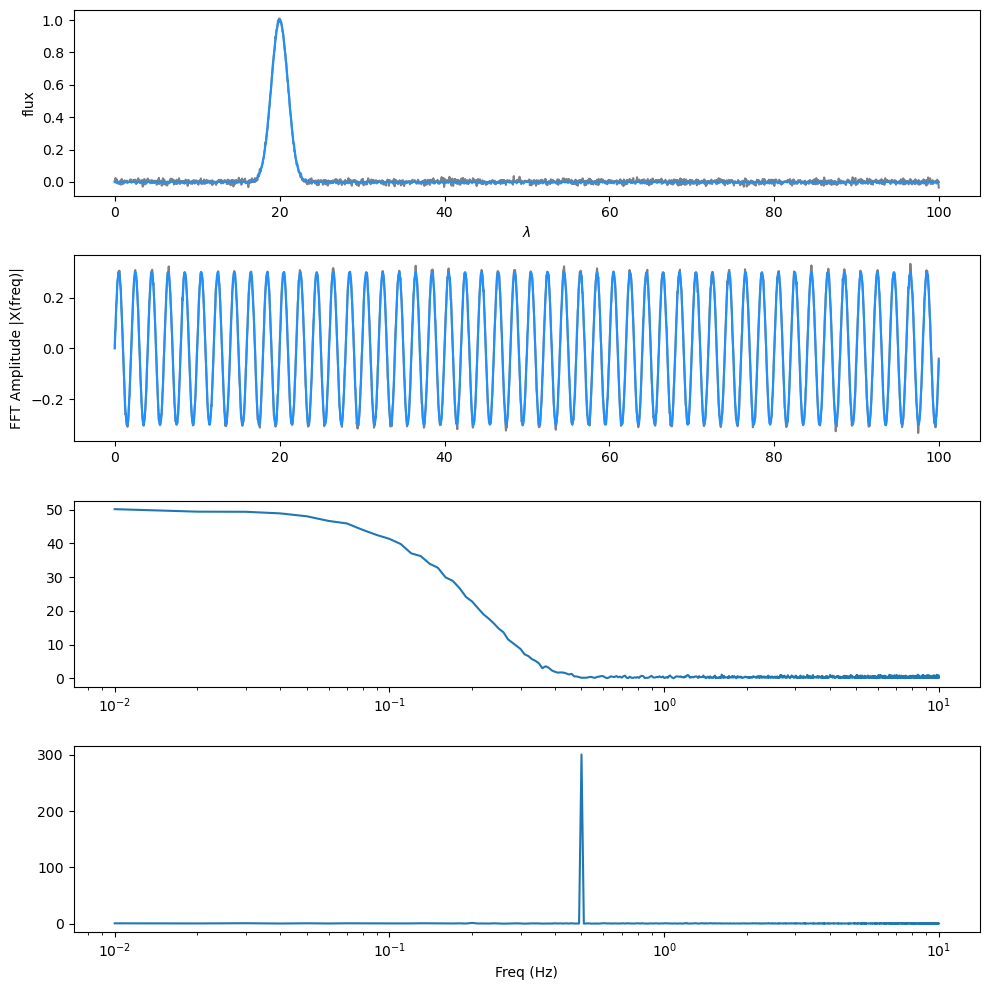

In [22]:
# Create the noisy data

np.random.seed(5)
N = 2000
dt = 0.05
noise = 0.01

t =  dt*np.arange(N) #N evenly spaced samples dt apart 
sr = 1./dt  # samples per interval 

freq1 = np.arange(N)/dt # N * 1/dt, by hand

freq2 = np.fft.fftfreq(N,dt)[1:N//2] # using convenience function in np.fft 
freq1 = freq2
h1 = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2) #gaussian signal
h2 = 0.3*np.sin(2*np.pi*0.5*t) # periodic signal 
hN1 = h1 + np.random.normal(0, noise, size=h1.shape)
hN2 = h2 + np.random.normal(0, noise, size=h2.shape)


fig = plt.figure(figsize=(10, 10))


# First plot: noisy signal
ax = fig.add_subplot(411)
ax.plot(t, hN1, '-', c='gray', label = 'signal + noise')
ax.plot(t, h1, c = 'dodgerblue', label = 'signal')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

ax = fig.add_subplot(412)
ax.plot(t, hN2, '-', c='gray', label = 'signal + noise')
ax.plot(t, h2, c = 'dodgerblue', label = 'signal')
plt.ylabel('FFT Amplitude |X(freq)|')

#plt.xlim(0, 10)
# plot the FFTs

ax = fig.add_subplot(413)

ax.plot(freq2,np.abs(np.fft.fft(hN1)[1:N//2]))
ax.set_xscale('log')
#plt.xlim(0, 10)

ax = fig.add_subplot(414)
ax.plot(freq2,np.abs(np.fft.fft(hN2)[1:N//2]))
ax.set_xscale('log')
#plt.xlim(0, 10)
#plotting code goes here 

plt.xlabel('Freq (Hz)')
#plt.xlim(0, 10)

plt.tight_layout()

In [53]:
np.argmax(np.abs(np.fft.fft(h2)**2))
freq2[50]

0.025

## Part b) Low Pass Filtering 

Write a function that returns 1 for frquencies below some critical value and 0 for values above that critical value. The numpy piecewise and lambda functions may be helpful, as before, an example of the syntax is in the documentation for numpy.piecewise. After filtering your signal from part a plot the original signal and the inverse transform of the filtered signal. Repeat this exercise for the different functions you plotted in part a. How is the recovered signal different? Repeat again for varying noise amplitudes.

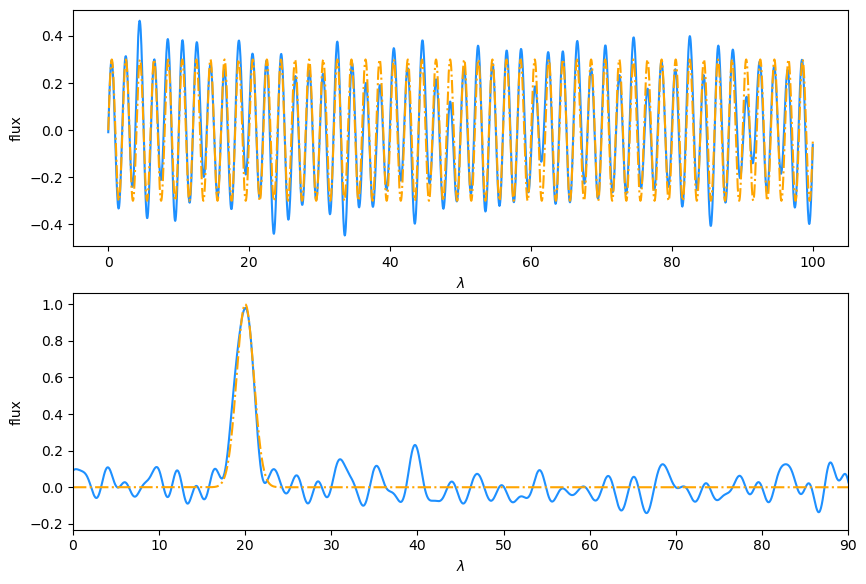

In [30]:
def low_pass(nu, nu_c):
    return np.piecewise(nu, [np.abs(nu) <= nu_c, np.abs(nu) > nu_c], [lambda nu: 1, lambda nu: 0])

noise = 0.3
hN1 = h1 + np.random.normal(0, noise, size=h1.shape)
hN2 = h2 + np.random.normal(0, noise, size=h2.shape)

freq = np.fft.fftfreq(N, dt)

fig = plt.figure(figsize=(10, 6.75))

ax = fig.add_subplot(211)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

ax.plot(t, np.fft.ifft(low_pass(freq, 0.5)*np.fft.fft(hN2)), c = 'dodgerblue')

ax.plot(t, h2, label = 'signal', c = 'orange', ls = '-.')

ax = fig.add_subplot(212)

ax.plot(t,np.fft.ifft(low_pass(freq,0.5)*(np.fft.fft(hN1))),c='dodgerblue')
ax.plot(t, h1, label = 'signal', c = 'orange', ls = '-.')

ax.set_xlim(0, 90)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

plt.show()

### Problem 2: Optimal Filtering 

In the lecture, we discussed high pass and low pass filters. Another common filter you may encounter is the "Wiener Filter" which is an 'optimal filter' in the following sense. 

Suppose you have a signal you're interested in which we can call u(t). Rather than being a pure measurement of some underlying process, suppose u(t) is the product of a measurement made by some imperfect instrument with a response function u(t). The total observed signal is then the convolution of the signal we're interested in and the instrument response,

$$ 
s(t) = \int r(\tau) u(t-\tau) d\tau
$$

Let us also suppose, for complexity's sake, that the signal s(t) is not measured independent of noise contributions.That is, we want to infer u(t) from c(t), where 

$$
c(t) = s(t) + n(t) 
$$

where n(t) is some noise signal. How might we proceed? We want to find a filter that retains as much information from the original signal as possible while discarding information from the noise and deconvolving with respect to the instrument response. We can quantify our error in the least squares sense via

$$
\int | \tilde{u}(t) - u(t) |^2 dt = \int |\tilde{U}(f) - U(f)|^2 df 
$$

where the reconstructed signal is given by 

$$
\tilde{U}(f) = \frac{C(f) \Phi(f)}{R(f)}
$$

Minimizing the least squares error and plugging in all of the above expressions yields an 'optimal' filter:

$$
\Phi(f) = \frac{ |S(f)|^2 }{|S(f)|^2 + |N(f)|^2} 
$$

#### Part A) Why is this an optimal filter? Hint: In what limits does each term in the filter 'matter more'? 

#### Part B) Estimates of the Noise Power

Using the Wiener filter in practice requires you to have an estimate of the signal and noise spectra (and their sum) in advance. While this is theoretically problematic, in practice it's rarely an issue. We can proceed in two ways. A more sophisticated method is to define a signal and noise function with a functional form close to those expected in your simulated signal from part a. Then compute the filter and filter the total signal to recover the component of interest. Alternatively, it is often easier to just approximate the signal PSD as the total PSD of the observed signal and assume the noise is flat in frequency space. Try both. Some code for achieving this is outlined below.

In [32]:
from scipy import fftpack
from scipy import optimize

In [36]:
# compute the PSD of the input
N = len(t)
Df =  1./N /(t[1]-t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2)) # shifts the central frequency to zero 

H = np.fft.fft(hN2)
PSD = np.abs(H)**2

def signal(x,A,width):
    width = np.abs(width) + 1e-99  
    return A * np.exp(-0.5 * (x/width)**2)

def noise(x,n):
    return (n * np.ones(x.shape))

# make some intelligent choices for 'guess' for each of the above parameters of your model functions:
# hint, what do all of the terms in the PSD tell you about the signal?

amp_guess = np.max(PSD[1:])
width_guess = np.min(np.abs(f[PSD < np.mean(PSD[1:])]))
signal_params = (amp_guess, width_guess)

noise_params = (np.mean(PSD[1:]),)

# now fit for the signal - noise:

def min_func(v): 
    # what should the minimum function return? What are you trying to minimize when you fit?
    return (np.sum((PSD[1:] - signal(f[1:], v[0], v[1]) - noise(f[1:], v[2]))**2))

v0 = tuple(signal_params) + tuple(noise_params)
v = optimize.minimize(min_func, v0, method='Nelder-Mead')['x']

#### Part C) Implementing a Wiener Filter on a Noisy Signal 

Now implement both versions of the Wiener filter - based on the fit or directly from the PSD of the total observed signal and compare the results. 

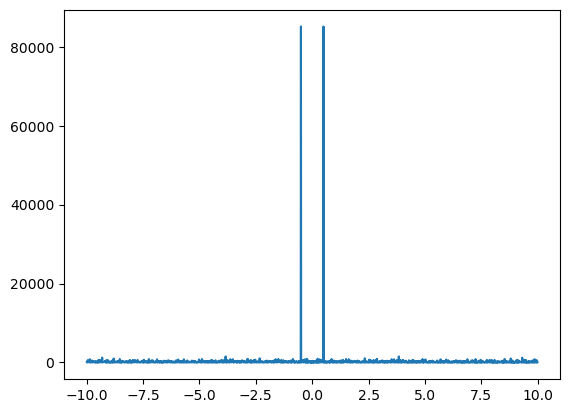

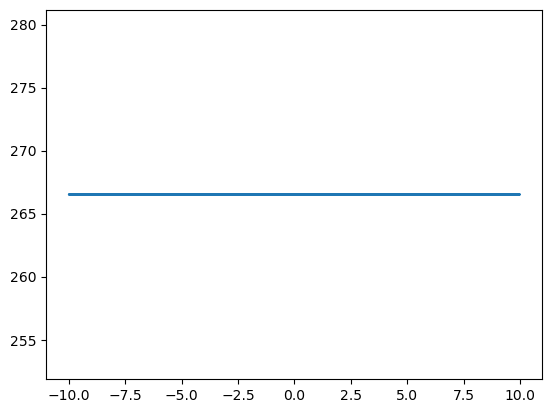

/Users/kailanathaniel/mambaforge/envs/lsstc_dsfp/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


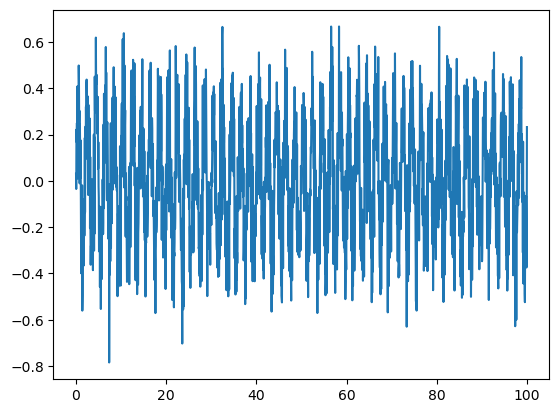

In [37]:
# P_S = signal(f, v[0], v[1])

P_S = PSD

P_N = noise(f, v[2])
Phi = P_S / (P_S + P_N)
Phi[0] = 1  # correct for DC offset

# Use Phi to filter and smooth the values
h_smooth = fftpack.ifft(Phi * H)

plt.plot(f, P_S)
plt.show()
plt.plot(f, P_N)
plt.show()

plt.plot(t, h_smooth)

### Problem 3: Sampling and Aliasing

We saw in the lecture that signals can be reconstructed if they are sampled at rates greater than the Nyquist frequency. What happens if we sample at rates that are 'too low'? The answer is that power from frequencies too low to be captured by a given sampling rate is misidentified as coming from frequencies that are measured. Let's consider two similar functions,

$$
f(t) = \cos\left(\frac{3 \pi}{2} t\right) 
$$

and 

$$
g(t) = \cos\left(\frac{\pi}{2} t\right)
$$

For different numbers of samples. 

### Part a) Starting in the Time Domain, plot the functions f(t) and g(t) over the interval (-4, 4) for n = 9 samples and n = 18 samples. From your plot, make sure you understand why undersampling leads to aliasing. Explain the origin of the term 'aliasing'. How did I pick this interval and this number of samples?

Hint: The word alias is defined as "an assumed or additional name that a person sometimes uses"

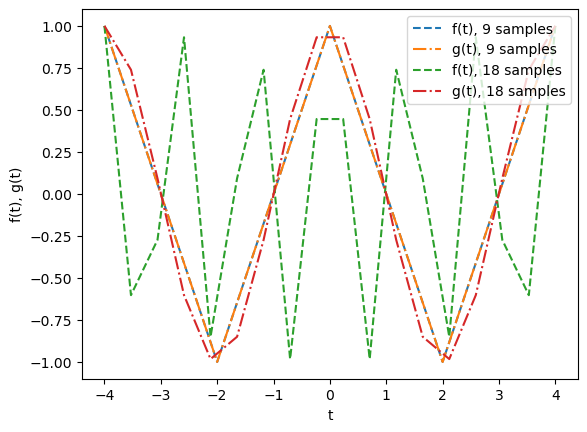

In [41]:
t1 = np.linspace(-4,4,9)
t2 = np.linspace(-4,4,18)

plt.plot(t1, np.cos(3*np.pi*t1/2),'--',label='f(t), 9 samples')
plt.plot(t1, np.cos(np.pi*t1/2),'-.',label='g(t), 9 samples')

plt.plot(t2, np.cos(3*np.pi*t2/2),'--',label='f(t), 18 samples')
plt.plot(t2, np.cos(np.pi*t2/2),'-.',label='g(t), 18 samples')

# plt.grid()
plt.xlabel('t')
plt.ylabel('f(t), g(t)')
plt.legend(loc = 'upper right')

### Part B) Let's now plot the Fourier Transforms of each signal. 

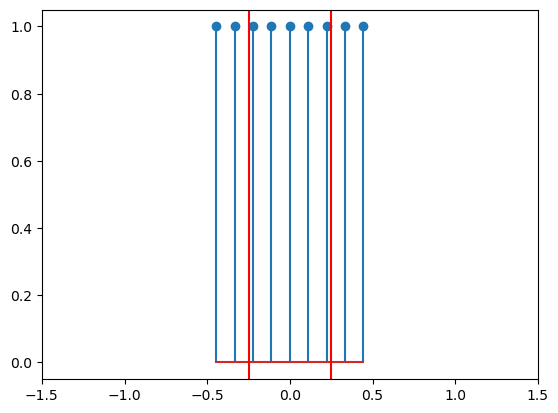

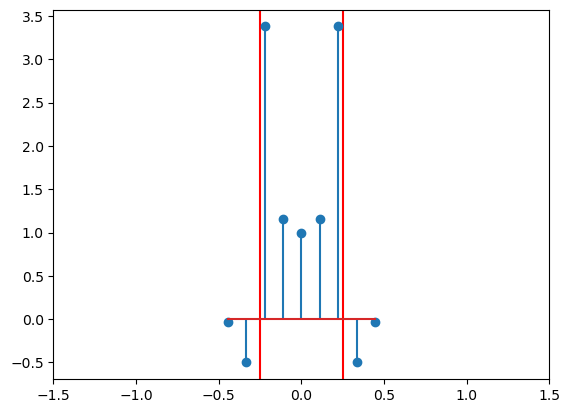

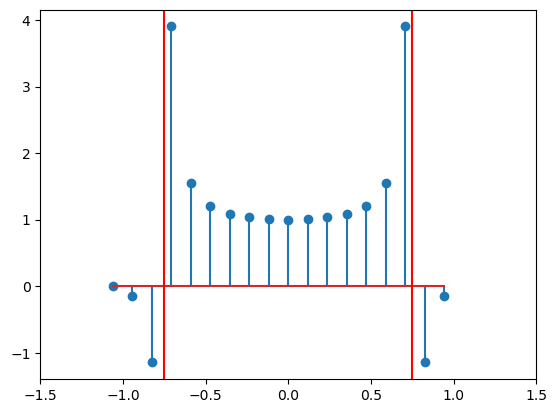

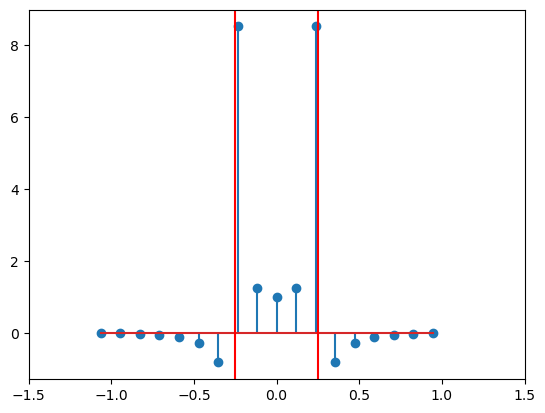

In [43]:
N1 = 9
N2 = 18

t1,dt1 = np.linspace(-4, 4, N1, retstep = True)
t2,dt2 = np.linspace(-4, 4, N2, retstep = True)

freq1 = np.fft.fftfreq(N1, dt1)
freq2 = np.fft.fftfreq(N2, dt2)

H1 = np.fft.fft(np.cos(2*np.pi*t1/2))
H2 = np.fft.fft(np.cos(np.pi*t1/2))

H3 = np.fft.fft(np.cos(3*np.pi*t2/2))
H4 = np.fft.fft(np.cos(np.pi*t2/2))

plt.stem(freq1, H1.real)

plt.axvline(1/4,color='r')
plt.axvline(-1/4,color='r')
plt.xlim(-1.5, 1.5)
plt.show()

plt.axvline(1/4,c='r')
plt.axvline(-1/4,c='r')
plt.stem(freq1, H2.real)
plt.xlim(-1.5,1.5)

plt.show()


plt.stem(freq2, H3.real)
plt.axvline(3/4,c='r')
plt.axvline(-3/4,c='r')
plt.xlim(-1.5,1.5)

plt.show()

plt.stem(freq2, H4.real)

plt.axvline(1/4,c='r')
plt.axvline(-1/4, c='r')
plt.xlim(-1.5,1.5)

plt.show()